# Mixing Cross-Sectional Reversal + Momentum

This notebook combines two diversified sleeves on the same hourly crypto panel:

- **Reversal** (short-horizon mean reversion)  
- **Momentum** (long-horizon cross-sectional trend)

We evaluate each sleeve net of costs and two portfolio mixes:
1) **Static 50/50**, and 2) **Equal-Vol** (volatility-balanced).  
Diagnostics include cumulative **log** returns, **90-day rolling Sharpe**, and sleeve **correlation**.


In [7]:
# --- Core ---
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import product
import matplotlib.pyplot as plt
import sys

# --- Display ---
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 200)

# --- Paths ---
PROJECT_ROOT = Path.cwd().parent          # .../crypto-stat-arb
SRC_DIR = PROJECT_ROOT / "src"            # .../crypto-stat-arb/src
PKG_DIR = SRC_DIR / "crypto_stat_arb"     # .../crypto-stat-arb/src/crypto_stat_arb
DATA_DIR = SRC_DIR / "data"               # .../crypto-stat-arb/src/data

if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# --- Config ---
from crypto_stat_arb.config import ANNUALIZATION, COST_BPS, COST_RATE
from crypto_stat_arb.io import load_panels
from crypto_stat_arb.signals import cs_momentum_weights, cs_reversal_weights
from crypto_stat_arb.portfolio import downsample_weights
from crypto_stat_arb.backtest import backtest, perf_stats
from crypto_stat_arb.stats import rolling_sharpe

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_DIR:", SRC_DIR)
print("PKG_DIR exists:", PKG_DIR.exists())
print("DATA_DIR:", DATA_DIR)
print("ANNUALIZATION:", ANNUALIZATION, "| COST_BPS:", COST_BPS, "| COST_RATE:", COST_RATE)

PROJECT_ROOT: C:\Users\Cameron Collins\crypto-stat-arb
SRC_DIR: C:\Users\Cameron Collins\crypto-stat-arb\src
PKG_DIR exists: True
DATA_DIR: C:\Users\Cameron Collins\crypto-stat-arb\src\data
ANNUALIZATION: 8760 | COST_BPS: 7 | COST_RATE: 0.0007


In [8]:
# Load price/return panels via helper (keeps columns consistent, raw otherwise)
px, ret = load_panels(DATA_DIR)

print("Coverage window:", ret.index.min(), "→", ret.index.max(), f"({len(ret):,} bars)")
print("N assets:", ret.shape[1])
print("Max NA frac:", float(ret.isna().mean().max()))

# Minimal gap handling if needed (keep behavior consistent with your EDA)
if ret.isna().any().any():
    ret = ret.ffill().dropna(how="any")
    px  = px.loc[ret.index, ret.columns]
    print("After fill/drop:", ret.shape)

BENCH = "BTCUSDT" if "BTCUSDT" in ret.columns else None

Coverage window: 2023-01-01 01:00:00+00:00 → 2025-08-14 00:00:00+00:00 (22,944 bars)
N assets: 12
Max NA frac: 0.0


In [9]:
# --- Best params ---
params_rev = {"k": 4, "band": 2.5, "beta_win": 168, "vol_win": 24}
every_rev  = 24             # daily rebalance

params_mom = {"k": 400, "band": 2.5, "beta_win": None, "vol_win": None}
every_mom  = 720            # ~monthly rebalance

# --- Compute weights ---
w_rev = cs_reversal_weights(ret, **params_rev)
w_rev = downsample_weights(w_rev, every=every_rev)

w_mom = cs_momentum_weights(ret, **params_mom)
w_mom = downsample_weights(w_mom, every=every_mom)

# --- Backtest sleeves ---
net_rev, gross_rev, summ_rev = backtest(w_rev, ret, cost_rate=COST_RATE)
net_mom, gross_mom, summ_mom = backtest(w_mom, ret, cost_rate=COST_RATE)

print("Reversal summary:")
display(pd.DataFrame(summ_rev).T.round(4))
print("Momentum summary:")
display(pd.DataFrame(summ_mom).T.round(4))

# Correlation between streams
print("Corr(net_rev, net_mom) =", float(pd.concat([net_rev, net_mom], axis=1).corr().iloc[0,1]))

Reversal summary:


,sharpe_gross,sharpe_net,ann_ret_gross,ann_ret_net,ann_vol_gross,ann_vol_net,turnover_bar,turnover_py,cost_py
0,2.066800,1.767000,0.428500,0.366200,0.207300,0.207200,0.010200,88.997400,0.062300


Momentum summary:


,sharpe_gross,sharpe_net,ann_ret_gross,ann_ret_net,ann_vol_gross,ann_vol_net,turnover_bar,turnover_py,cost_py
0,1.524400,1.506900,0.279900,0.276700,0.183600,0.183600,0.000500,4.581600,0.003200


Corr(net_rev, net_mom) = -0.05469209004816021


In [10]:
def annualized_vol(x: pd.Series) -> float:
    return x.std() * np.sqrt(ANNUALIZATION)

# 50/50 simple mix
net_mix_5050 = 0.5 * net_rev + 0.5 * net_mom

# Equal-vol mix
vol_rev = annualized_vol(net_rev.dropna())
vol_mom = annualized_vol(net_mom.dropna())
scale_rev = 1.0 if vol_rev == 0 else (1.0 / vol_rev)
scale_mom = 1.0 if vol_mom == 0 else (1.0 / vol_mom)

net_rev_ev = net_rev * scale_rev
net_mom_ev = net_mom * scale_mom
net_mix_eqvol = 0.5 * net_rev_ev + 0.5 * net_mom_ev

def summarize(name, x):
    s = perf_stats(x.dropna())
    return pd.Series(s, name=name)

summary_tbl = pd.concat([
    summarize("Reversal", net_rev),
    summarize("Momentum", net_mom),
    summarize("Mix 50/50", net_mix_5050),
    summarize("Mix Equal-Vol", net_mix_eqvol),
], axis=1).T

print("Mixed portfolio summaries:")
display(summary_tbl.round(3))

Mixed portfolio summaries:


,ann_ret,ann_vol,sharpe
Reversal,0.366000,0.207000,1.767000
Momentum,0.277000,0.184000,1.507000
Mix 50/50,0.321000,0.135000,2.388000
Mix Equal-Vol,1.637000,0.687000,2.381000


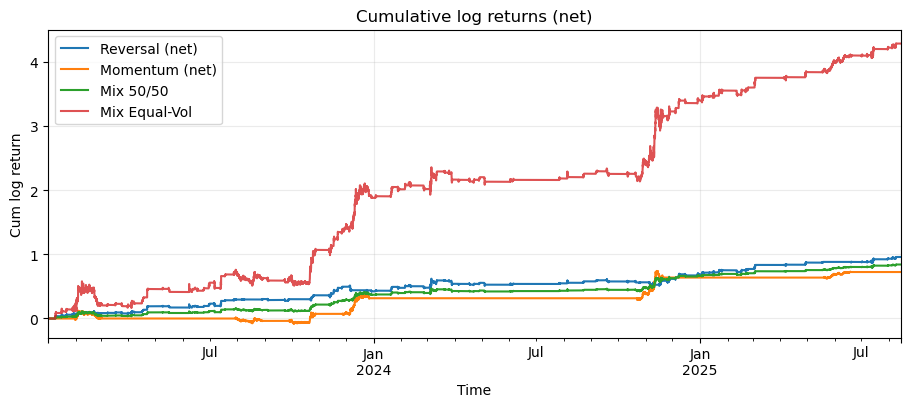

In [11]:
# Cumulative (log) curves
fig, ax = plt.subplots(1, 1, figsize=(11,4))
net_rev.cumsum().plot(ax=ax, label="Reversal (net)")
net_mom.cumsum().plot(ax=ax, label="Momentum (net)")
net_mix_5050.cumsum().plot(ax=ax, label="Mix 50/50")
net_mix_eqvol.cumsum().plot(ax=ax, label="Mix Equal-Vol", alpha=0.8)
ax.set_title("Cumulative log returns (net)")
ax.grid(True, alpha=0.25); ax.legend(); ax.set_xlabel("Time"); ax.set_ylabel("Cum log return")
plt.show()

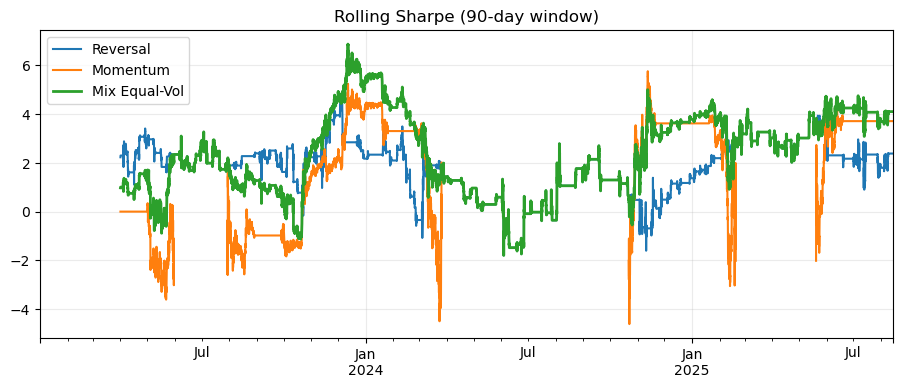

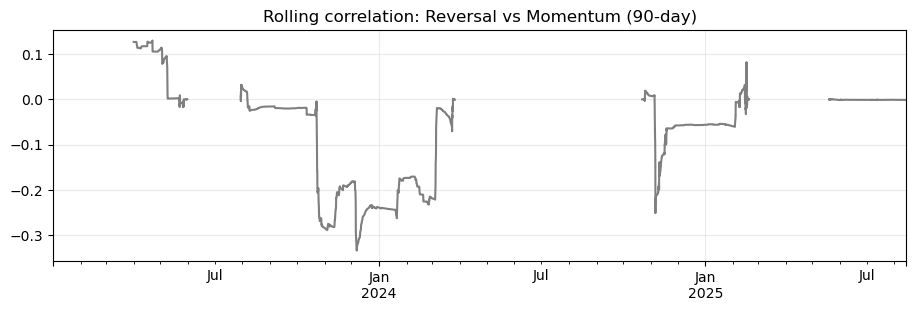

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(11,4))
rolling_sharpe(net_rev).plot(ax=ax, label="Reversal")
rolling_sharpe(net_mom).plot(ax=ax, label="Momentum")
rolling_sharpe(net_mix_eqvol).plot(ax=ax, label="Mix Equal-Vol", lw=2)
ax.set_title("Rolling Sharpe (90-day window)"); ax.grid(True, alpha=0.25); ax.legend()
plt.show()

# Rolling correlation between sleeves (90-day)
rho = pd.concat([net_rev, net_mom], axis=1).rolling(90*24).corr().unstack().iloc[:,1]
fig, ax = plt.subplots(1,1, figsize=(11,3))
rho.plot(ax=ax, color="tab:gray")
ax.set_title("Rolling correlation: Reversal vs Momentum (90-day)"); ax.grid(True, alpha=0.25)
plt.show()

Static optimizer → w_momentum=0.50, Sharpe=2.388


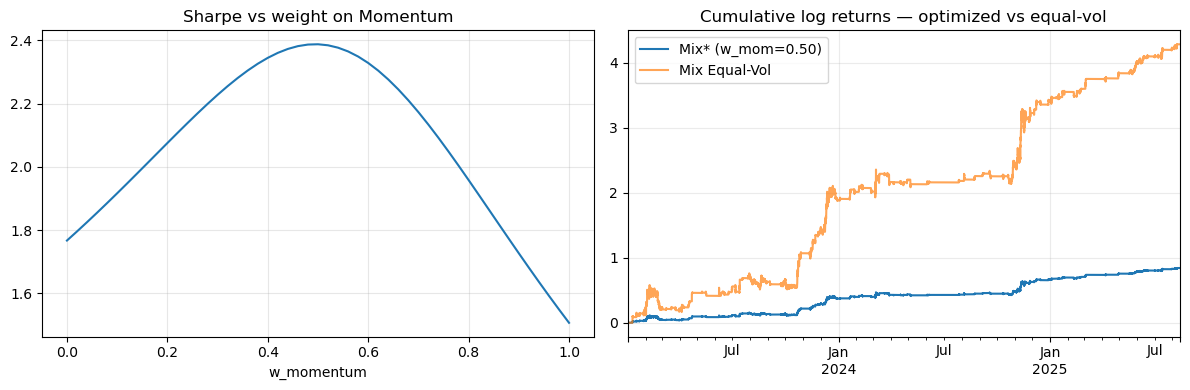

In [12]:
# Choose a static weight w for Momentum
ws = np.linspace(0, 1, 51)
shs = []
for w in ws:
    mix = (1-w)*net_rev + w*net_mom
    s = perf_stats(mix.dropna())["sharpe"]
    shs.append(s)

w_star = float(ws[np.nanargmax(shs)])
mix_star = (1-w_star)*net_rev + w_star*net_mom
print(f"Static optimizer → w_momentum={w_star:.2f}, Sharpe={perf_stats(mix_star)['sharpe']:.3f}")

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(ws, shs); ax[0].set_title("Sharpe vs weight on Momentum"); ax[0].set_xlabel("w_momentum"); ax[0].grid(True, alpha=0.3)
mix_star.cumsum().plot(ax=ax[1], label=f"Mix* (w_mom={w_star:.2f})")
net_mix_eqvol.cumsum().plot(ax=ax[1], label="Mix Equal-Vol", alpha=0.7)
ax[1].set_title("Cumulative log returns — optimized vs equal-vol"); ax[1].grid(True, alpha=0.25); ax[1].legend()
plt.tight_layout(); plt.show()

## Results & Interpretation

**Single-sleeve performance (net):**
- **Reversal:** Sharpe **1.77**, ann. ret **0.366**, ann. vol **0.207**, turnover ≈ **89/yr** (cost_py ≈ **0.062**).
- **Momentum:** Sharpe **1.51**, ann. ret **0.277**, ann. vol **0.184**, turnover ≈ **4.6/yr** (cost_py ≈ **0.003**).

**Diversification:**
- Sleeve correlation **Corr(net_rev, net_mom) ≈ −0.055**, i.e., near zero/slightly negative → strong diversification benefit.

**Mixed portfolios (net):**
- **Static 50/50:** ann. ret **0.321**, ann. vol **0.135**, **Sharpe 2.388** (highest Sharpe).  
- **Equal-Vol:** ann. ret **1.637**, ann. vol **0.687**, **Sharpe 2.381** (similar Sharpe, much higher risk/return).

### What the charts show
- **Cumulative log returns:** The **Equal-Vol mix** (red) compounds the fastest, reflecting its higher risk budget; **50/50** sits between the sleeves, and **Reversal** outpaces **Momentum** for most of the sample.
- **Rolling 90-day Sharpe:** The **Equal-Vol mix** (green) is generally highest and more stable, while **Momentum** occasionally dips sharply; **Reversal** is steadier. The mixes rarely go negative, confirming diversification benefits.
- **Sharpe vs weight on Momentum:** The curve is **concave** with an optimum near **w_mom ≈ 0.50**, consistent with the reported **max Sharpe ≈ 2.39**.  
  In the side-by-side plot, **Equal-Vol** beats the optimized 50/50 in *cumulative* return because it runs **higher volatility** (Sharpe is similar, but risk—and thus return—is larger).

**Takeaways**
- Reversal and momentum are **complementary**; their near-zero correlation makes mixing highly effective.
- If targeting **maximum Sharpe**, a **static ~50/50** split is sufficient.  
- If targeting **higher return with acceptable Sharpe**, **Equal-Vol** leverages both sleeves more aggressively.
- Momentum’s **very low turnover** makes it inexpensive; Reversal drives most of the alpha but at higher trading cost—together they deliver a strong, balanced profile.
